Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
dtype: int64
0
Churn                 2
AccountWeeks        212
ContractRenewal       2
DataPlan              2
DataUsage           174
CustServCalls        10
DayMins            1667
DayCalls            119
MonthlyCharge       627
OverageFee         1024
RoamMins            162
dtype: int64
Churn                int64
AccountWeeks         int64
ContractRenewal      int64
DataPlan             int64
DataUsage          float64
CustServCalls        int64
DayMins            float64
DayCalls             int64
MonthlyCharge      float64
OverageFee         float64
RoamMins           float64
dtype: object


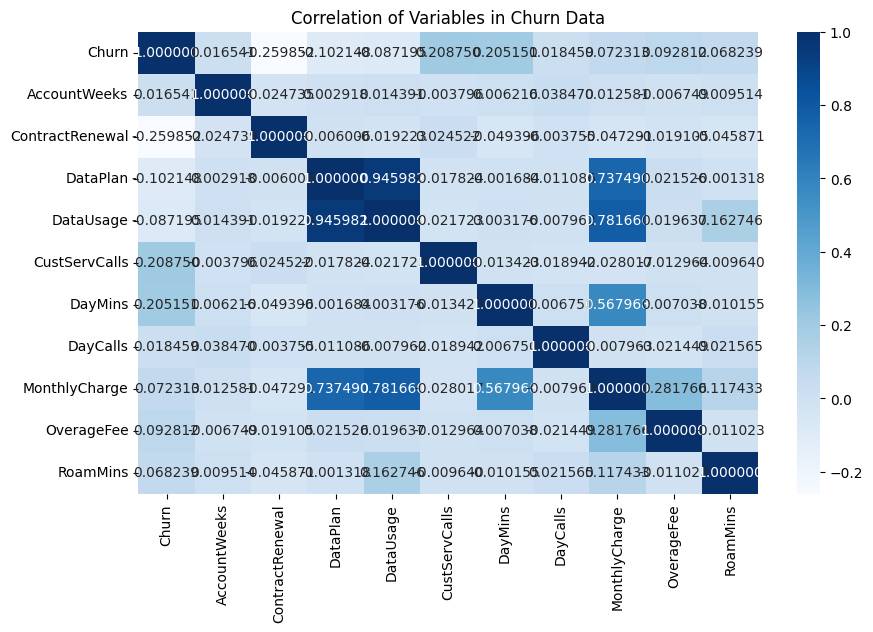

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,BaggingClassifier
import warnings
import statsmodels.api as sm
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,confusion_matrix
import pickle


warnings.filterwarnings("ignore")


df = pd.read_csv("../data/telecom_churn.csv",delimiter=',')

df.head(10)
print(df.isnull().sum())
print(df.duplicated().sum())
print(df.nunique())
print(df.dtypes)



plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), fmt="f",cmap="Blues",annot=True)
plt.title("Correlation of Variables in Churn Data")
plt.show()


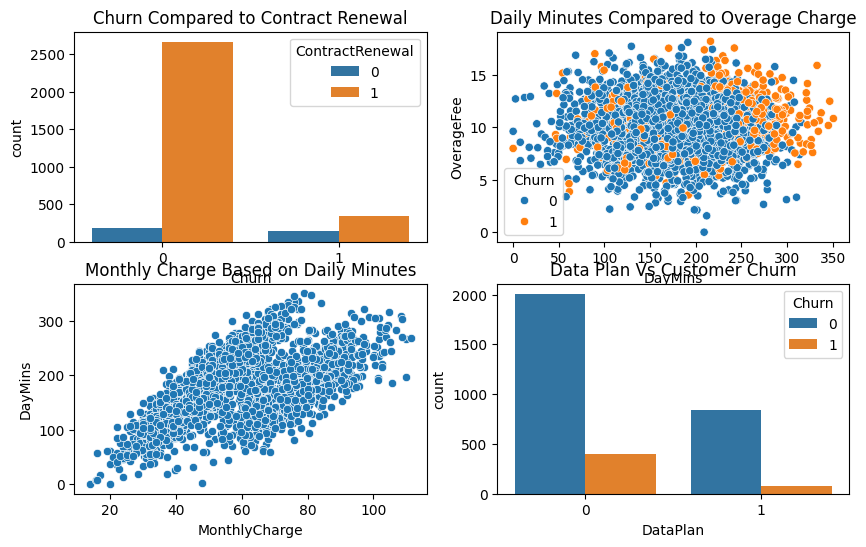

In [2]:

fig,axs = plt.subplots(2,2,figsize=(10,6))
sns.countplot(data=df,ax=axs[0,0],x='Churn',hue="ContractRenewal")
axs[0,0].set_title("Churn Compared to Contract Renewal")

sns.scatterplot(data=df,ax=axs[0,1],x='DayMins',y='OverageFee',hue="Churn")
axs[0,1].set_title("Daily Minutes Compared to Overage Charge")

sns.scatterplot(data=df,ax=axs[1,0],x='MonthlyCharge',y='DayMins')
axs[1,0].set_title("Monthly Charge Based on Daily Minutes")

sns.countplot(data=df,ax=axs[1,1],x='DataPlan',hue='Churn')
axs[1,1].set_title("Data Plan Vs Customer Churn")
plt.show()

In [3]:

"""Even though the target is binary, OLS is still better than GLM to see which features are correlated
in terms of statistically significance"""

X = df.drop('Churn',axis=1)
y = df['Churn']

olsmodel = sm.OLS(exog=sm.add_constant(X),endog=y).fit()
print(olsmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     70.31
Date:                Wed, 02 Apr 2025   Prob (F-statistic):          9.57e-131
Time:                        12:20:29   Log-Likelihood:                -929.44
No. Observations:                3333   AIC:                             1881.
Df Residuals:                    3322   BIC:                             1948.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1433      0.054     

In [4]:

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def evaluate(y_test,pred,pred_prob,model_name,cv_scores):


    result = {
        "Model": model_name,
        "Accuracy": acc,
        "RocAucScore": roc,
        "CVscores": cv_scores.mean()
    }

    return result
    



model_dict = []


models = {
    "LogisticRegression":LogisticRegression(),
    "RandomForest":RandomForestClassifier(),
    "GradientBoostingClassifier":GradientBoostingClassifier(),
    "BaggingClassifier":BaggingClassifier(),
    }



for model_name,model in models.items():
    model.fit(X_train_scaled,y_train)
    pred = model.predict(X_test_scaled)
    pred_prob = model.predict_proba(X_test_scaled)[:,1]
    acc = accuracy_score(y_test,pred)
    roc = roc_auc_score(y_test, pred_prob)
    cv_scores = cross_val_score(model, X_train_scaled,y_train,cv=10,scoring="roc_auc")
    model_results = evaluate(y_test, pred, pred_prob, model_name, cv_scores)
    model_dict.append(model_results)



df_results = pd.DataFrame(model_dict)
print(df_results.head())


                        Model  Accuracy  RocAucScore  CVscores
0          LogisticRegression  0.859070     0.831473  0.810141
1                RandomForest  0.925037     0.924212  0.888558
2  GradientBoostingClassifier  0.937031     0.908433  0.904041
3           BaggingClassifier  0.913043     0.888028  0.874119


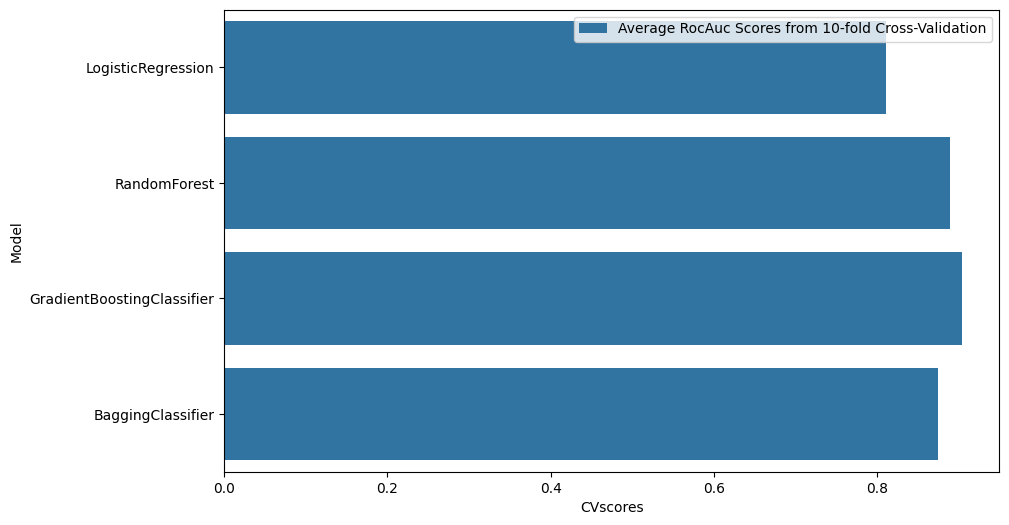

In [5]:
plt.figure(figsize=(10,6))
sns.barplot(x=df_results['CVscores'],y=df_results['Model'],label="Average RocAuc Scores from 10-fold Cross-Validation")
plt.legend()
plt.show()

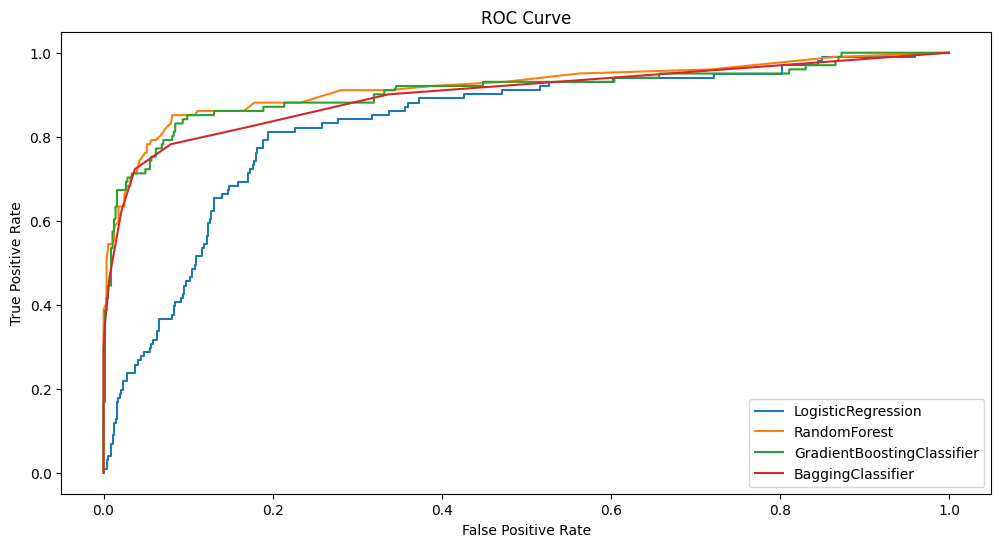

In [6]:

def plot_roc_curve(models,X_test_scaled,y_test):
    plt.figure(figsize=(12,6))
    
    for model_name, model in models.items():
        model.fit(X_train_scaled, y_train)
        pred_prob = model.predict_proba(X_test_scaled)[:,1]
        fpr, tpr, _ = roc_curve(y_test, pred_prob)
        plt.plot(fpr, tpr, label=model_name)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()



plot_roc_curve(models, X_test_scaled, y_test)


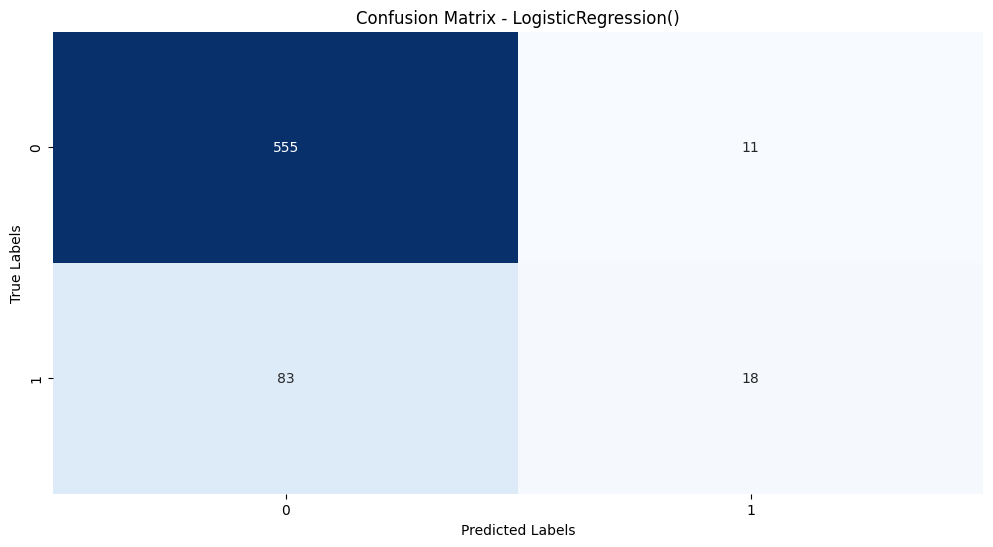

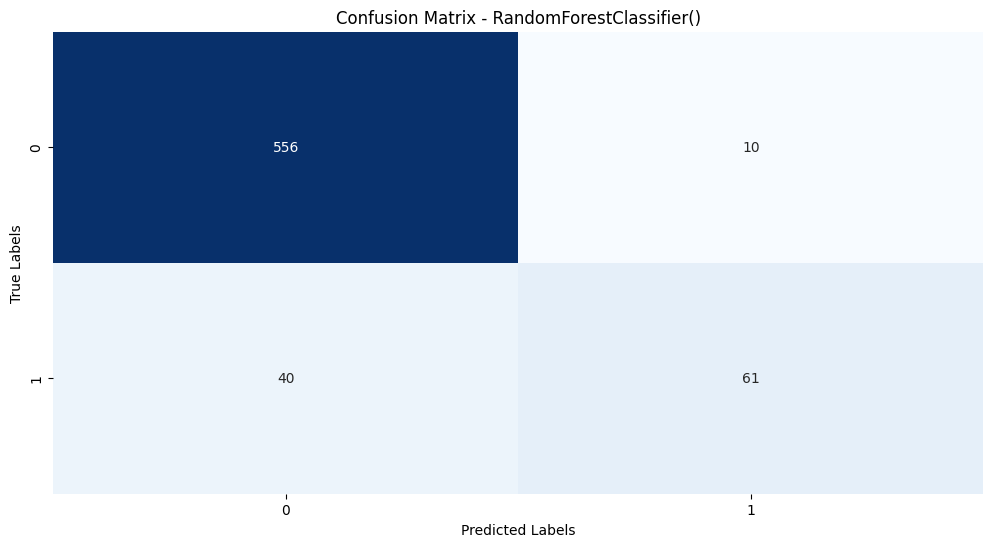

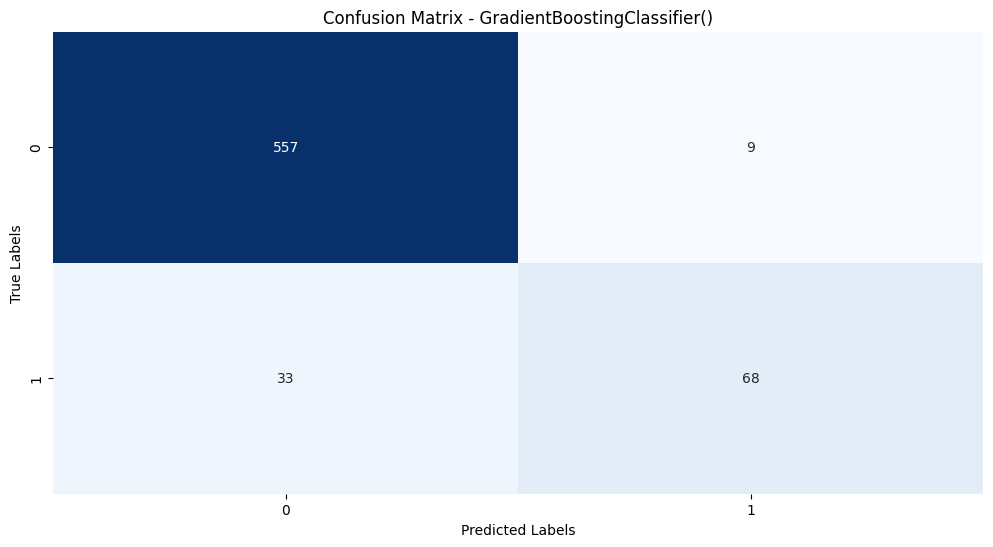

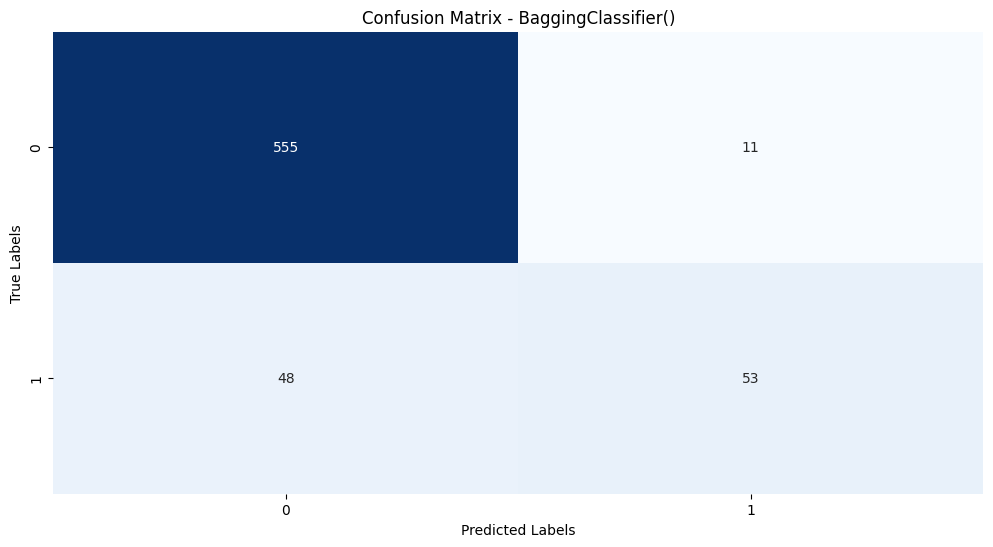

In [7]:
def plot_confusion_matrix(y_test, y_pred, models):
    conmap = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,6))
    sns.heatmap(conmap, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {models}')
    plt.show()




for model_name, model in models.items():

    model.fit(X_train_scaled,y_train)
    y_pred = model.predict(X_test_scaled)
    

    plot_confusion_matrix(y_test, y_pred, model)

In [8]:

"""Hyper Parameter Tuning through a Grid Search """

lr_params = {
    'C': [0.001,0.01,0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'max_iter':[5000,10000]
    
}



rfc_params = {
    'n_estimators': [50,100,200],
    'max_depth': [None,10,20],
    'min_samples_leaf':[1,2,4],
    'max_features': ['sqrt','log2',None],
    "criterion":["gini","entropy"]
}



gbc_params = {
    'n_estimators': [50,100,200],
    'learning_rate': [1,0.5,0.25,0.1,0.05,0.01],
    'max_depth': [3,4,5],
    'min_samples_split': [2,5,10],
}







BC_params = {
    'n_estimators': [50,100,200],
    'max_features': [1.0,0.8,0.6]
}



df.dtypes

best_scores = []


models = {
    "LogisticRegression":(LogisticRegression(),lr_params),
    "BaggingClassifier":(BaggingClassifier(),BC_params),
    "GradientBoostingClassifier":(GradientBoostingClassifier(),gbc_params),
    "RandomForestClassifier":(RandomForestClassifier(),rfc_params)
    }



for model_name,(model,params) in models.items():
    print(f'GridSearch For {model_name}:')
    clf = GridSearchCV(model, params,cv=4,scoring="roc_auc",n_jobs=-1).fit(X_train_scaled,y_train)
    print(f'Best Parameters for {model_name} : {clf.best_params_}')
    print(f'Best Average RocAuc Scores for: {model_name} : {clf.best_score_ * 100:.2f}%')
    best_scores.append({"Model":model_name,"RocScore":clf.best_score_})

best_scores_df = pd.DataFrame(best_scores)

print('Best Scores:\n')
print(best_scores_df.head())

GridSearch For LogisticRegression:
Best Parameters for LogisticRegression : {'C': 0.001, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Average RocAuc Scores for: LogisticRegression : 81.37%
GridSearch For BaggingClassifier:
Best Parameters for BaggingClassifier : {'max_features': 0.8, 'n_estimators': 100}
Best Average RocAuc Scores for: BaggingClassifier : 89.13%
GridSearch For GradientBoostingClassifier:
Best Parameters for GradientBoostingClassifier : {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}
Best Average RocAuc Scores for: GradientBoostingClassifier : 90.50%
GridSearch For RandomForestClassifier:
Best Parameters for RandomForestClassifier : {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 50}
Best Average RocAuc Scores for: RandomForestClassifier : 90.18%
Best Scores:

                        Model  RocScore
0          LogisticRegression  0.813685
1           BaggingClassif

In [9]:
"""Results of best model with optimized parameters"""


gradientboosting_clf = GradientBoostingClassifier(learning_rate=0.1,max_depth=3,min_samples_split=5,n_estimators=50)
gradientboosting_clf.fit(X_train_scaled,y_train)
y_pred = gradientboosting_clf.predict(X_test_scaled)
y_pred_prob = gradientboosting_clf.predict_proba(X_test_scaled)[:,1]
print('best accuracy score\n')
print(accuracy_score(y_test, y_pred))
print('RocScore from Gradient Boosting Clf with optimized hyper parameters\n')
print(roc_auc_score(y_test, y_pred_prob))

best accuracy score

0.9280359820089955
RocScore from Gradient Boosting Clf with optimized hyper parameters

0.9120718608963372


In [11]:

def predict(model,features):

    predictions = model.predict(features)
    pred_probabilities = model.predict_proba(features)[:,1]
    
    

    data = []
    for pred,pred_prob in zip(predictions,pred_probabilities):
        data.append([pred,pred_prob])
    
    return data,pred_probabilities





if __name__ == "__main__":
    
    with open("models/gbc_clf.pkl","rb") as f:
        model = pickle.load(f)
        
    with open("models/features.pkl",'rb') as f:
        features = pickle.load(f)
    
    predictions, pred_probabilities = predict(model, features)
    print('Predictions:')
    for i, (pred, prob) in enumerate(predictions):
        if (i+1) % 100== 0:
            print(f"Sample {i+1}: Prediction = {pred}, Probability of Churn = {prob:.2f}")

    print("Predicted Probabilities:")
    print(pred_probabilities)

Predictions:
Sample 100: Prediction = 0, Probability of Churn = 0.03
Sample 200: Prediction = 0, Probability of Churn = 0.03
Sample 300: Prediction = 0, Probability of Churn = 0.05
Sample 400: Prediction = 1, Probability of Churn = 0.88
Sample 500: Prediction = 0, Probability of Churn = 0.17
Sample 600: Prediction = 1, Probability of Churn = 0.76
Sample 700: Prediction = 0, Probability of Churn = 0.04
Sample 800: Prediction = 1, Probability of Churn = 0.88
Sample 900: Prediction = 0, Probability of Churn = 0.03
Sample 1000: Prediction = 0, Probability of Churn = 0.44
Sample 1100: Prediction = 0, Probability of Churn = 0.43
Sample 1200: Prediction = 1, Probability of Churn = 0.91
Sample 1300: Prediction = 0, Probability of Churn = 0.03
Sample 1400: Prediction = 1, Probability of Churn = 0.51
Sample 1500: Prediction = 0, Probability of Churn = 0.02
Sample 1600: Prediction = 0, Probability of Churn = 0.02
Sample 1700: Prediction = 0, Probability of Churn = 0.03
Sample 1800: Prediction = 0